## 4차 과제 - Hyperparameter Tuning을 해보자
- 주제: 하이퍼파라미터 튜닝 기법 학습
- 데이터: The History of Baseball(Pitching Data) https://www.kaggle.com/datasets/seanlahman/the-history-of-baseball?select=pitching.csv
- 사용 라이브러리: pandas, numpy, matplotlib, sklearn, imblearn, bayes_opt

### 1. EDA, 전처리

1.1 분석을 위해 사용될 라이브러리들을 import 하세요.

numpy, pandas, matplotlib, SMOTE, train_test_split, RandomForestClassifier, RandomizedSearchCV, GridSearchCV, BayesianOptimization, accuracy_score

In [ ]:
pip install bayesian-optimization

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from bayes_opt import BayesianOptimization

1.2 데이터를 불러오고 info()를 통해 데이터를 살펴보세요.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/pitching.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44139 entries, 0 to 44138
Data columns (total 30 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   player_id  44139 non-null  object 
 1   year       44139 non-null  int64  
 2   stint      44139 non-null  int64  
 3   team_id    44139 non-null  object 
 4   league_id  44008 non-null  object 
 5   w          44139 non-null  int64  
 6   l          44139 non-null  int64  
 7   g          44139 non-null  int64  
 8   gs         44139 non-null  int64  
 9   cg         44139 non-null  int64  
 10  sho        44139 non-null  int64  
 11  sv         44139 non-null  int64  
 12  ipouts     44138 non-null  float64
 13  h          44139 non-null  int64  
 14  er         44139 non-null  int64  
 15  hr         44139 non-null  int64  
 16  bb         44139 non-null  int64  
 17  so         44139 non-null  int64  
 18  baopp      42614 non-null  float64
 19  era        44049 non-null  float64
 20  ibb   

1.3 null 값이 있는 컬럼은 모두 삭제하겠습니다(원래는 다른 처리를 해야 하지만 컬럼 수는 충분하니까..ㅎㅎ 야구 잘 몰라서 그런 거 아닙니다.).

In [ ]:
df.dropna(axis=1, inplace=True)
print(df.columns)
df.head()

Index(['player_id', 'year', 'stint', 'team_id', 'w', 'l', 'g', 'gs', 'cg',
       'sho', 'sv', 'h', 'er', 'hr', 'bb', 'so', 'bk', 'r'],
      dtype='object')


,player_id,year,stint,team_id,w,l,g,gs,cg,sho,sv,h,er,hr,bb,so,bk,r
0,bechtge01,1871,1,PH1,1,2,3,3,2,0,0,43,23,0,11,1,0,42
1,brainas01,1871,1,WS3,12,15,30,30,30,0,0,361,132,4,37,13,0,292
2,fergubo01,1871,1,NY2,0,0,1,0,0,0,0,8,3,0,0,0,0,9
3,fishech01,1871,1,RC1,4,16,24,24,22,1,0,295,103,3,31,15,0,257
4,fleetfr01,1871,1,NY2,0,1,1,1,1,0,0,20,10,0,3,0,0,21


1.4 연도 별로 몇개의 데이터가 있는 지 확인 후 데이터가 얼마 없는 과거 데이터는 삭제하겠습니다. 이를 위해 연도 별 데이터 수를 계산하고 line plot으로 그리세요.

In [ ]:
df_year = df['year'].value_counts().sort_index()
df_year

year
1871     19
1872     23
1873     25
1874     17
1875     47
       ... 
2011    707
2012    722
2013    726
2014    746
2015    809
Name: count, Length: 145, dtype: int64

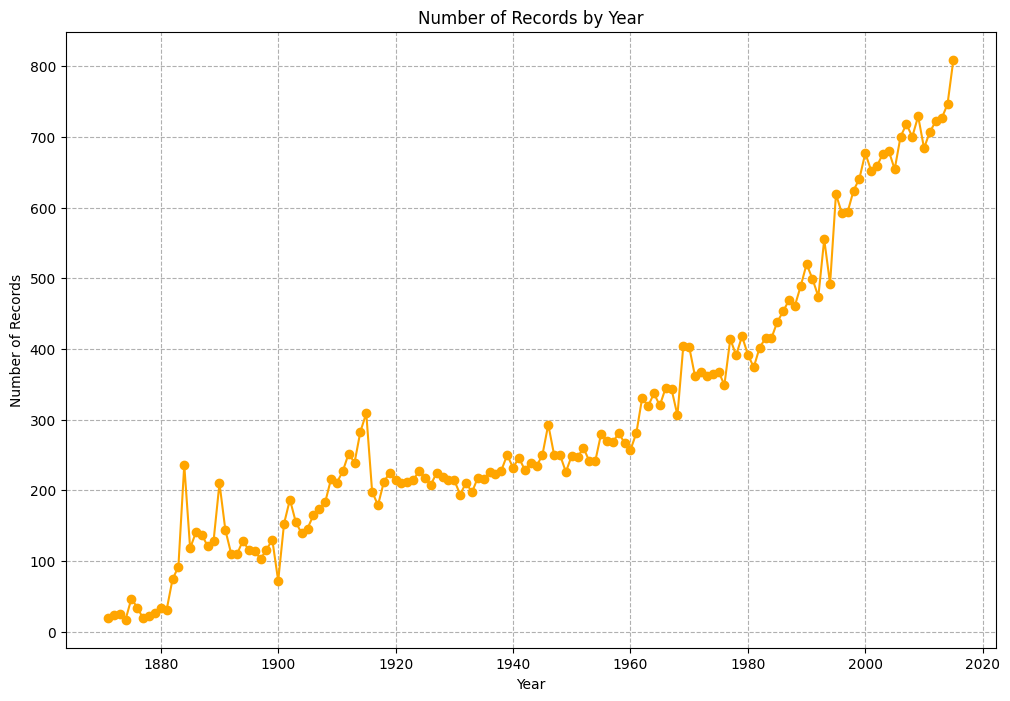

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(df_year.index, df_year.values, marker='o',color='orange')
plt.title('Number of Records by Year')
plt.xlabel('Year')
plt.ylabel('Number of Records')
plt.grid(linestyle='--')
plt.show()

In [ ]:
np.quantile(df_year.values,[0.25,0.5,0.75])

array([187., 246., 403.])

In [ ]:
# 중앙값보다 작은 값을 삭제한다.
year_keep = df_year[df_year > 246].index
df = df[df['year'].isin(year_keep)]
df

,player_id,year,stint,team_id,w,l,g,gs,cg,sho,sv,h,er,hr,bb,so,bk,r
4652,adamsba01,1912,1,PIT,11,8,28,21,11,2,0,169,55,4,35,63,0,73
4653,adamswi01,1912,1,SLA,2,3,13,5,0,0,0,50,20,0,19,16,0,32
4654,akersje01,1912,1,WS1,1,1,5,1,0,0,0,24,11,1,15,11,0,17
4655,alexape01,1912,1,PHI,19,17,46,34,25,3,3,289,97,11,105,195,0,133
4656,allenfr01,1912,1,BRO,3,9,20,15,5,1,0,119,44,1,57,58,0,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44134,youngch03,2015,1,KCA,11,6,34,18,0,0,0,91,42,16,43,83,0,44
44135,zieglbr01,2015,1,ARI,0,3,66,0,0,0,30,48,14,3,17,36,0,17
44136,zimmejo02,2015,1,WAS,13,10,33,33,0,0,0,204,82,24,39,164,1,89
44137,zitoba01,2015,1,OAK,0,0,3,2,0,0,0,12,8,4,6,2,0,8


1.5 보다 최신 분석을 위해 1980년 이후의 데이터만 남기고 몇개의 데이터가 남았는지 확인하세요.

In [ ]:
print(len(df[df['year']>=1980]))
df_new = df[df['year']>=1980]
df_new

21157


,player_id,year,stint,team_id,w,l,g,gs,cg,sho,sv,h,er,hr,bb,so,bk,r
22982,aasedo01,1980,1,CAL,8,13,40,21,5,1,2,193,79,13,66,74,1,83
22983,abbotgl01,1980,1,SEA,12,12,31,31,7,2,0,228,98,27,49,78,1,110
22984,alexado01,1980,1,ATL,14,11,35,35,7,1,0,227,108,20,74,114,0,120
22985,allarbr01,1980,1,TEX,0,1,5,2,0,0,0,13,9,0,10,10,0,13
22986,allenne01,1980,1,NYN,7,10,59,0,0,0,22,87,40,7,40,79,1,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44134,youngch03,2015,1,KCA,11,6,34,18,0,0,0,91,42,16,43,83,0,44
44135,zieglbr01,2015,1,ARI,0,3,66,0,0,0,30,48,14,3,17,36,0,17
44136,zimmejo02,2015,1,WAS,13,10,33,33,0,0,0,204,82,24,39,164,1,89
44137,zitoba01,2015,1,OAK,0,0,3,2,0,0,0,12,8,4,6,2,0,8


1.6 reset_index()를 통해 재배열하세요.

In [ ]:
df_new.reset_index(drop=True, inplace=True)
df_new

,player_id,year,stint,team_id,w,l,g,gs,cg,sho,sv,h,er,hr,bb,so,bk,r
0,aasedo01,1980,1,CAL,8,13,40,21,5,1,2,193,79,13,66,74,1,83
1,abbotgl01,1980,1,SEA,12,12,31,31,7,2,0,228,98,27,49,78,1,110
2,alexado01,1980,1,ATL,14,11,35,35,7,1,0,227,108,20,74,114,0,120
3,allarbr01,1980,1,TEX,0,1,5,2,0,0,0,13,9,0,10,10,0,13
4,allenne01,1980,1,NYN,7,10,59,0,0,0,22,87,40,7,40,79,1,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21152,youngch03,2015,1,KCA,11,6,34,18,0,0,0,91,42,16,43,83,0,44
21153,zieglbr01,2015,1,ARI,0,3,66,0,0,0,30,48,14,3,17,36,0,17
21154,zimmejo02,2015,1,WAS,13,10,33,33,0,0,0,204,82,24,39,164,1,89
21155,zitoba01,2015,1,OAK,0,0,3,2,0,0,0,12,8,4,6,2,0,8


1.7 투수의 승리 수를 예측해보겠습니다. w 컬럼의 value를 확인해보세요.

In [ ]:
df_new['w'].value_counts().sort_index()

w
0     5854
1     3197
2     2356
3     1744
4     1453
5     1114
6      878
7      730
8      557
9      560
10     450
11     434
12     384
13     317
14     287
15     242
16     193
17     125
18     102
19      61
20      53
21      32
22      17
23       7
24       8
25       1
27       1
Name: count, dtype: int64

1.8 0승 투수(출전하지 않은 경우도 존재)가 많으므로 승리 수가 0인 데이터는 삭제하겠습니다.

In [ ]:
df_new = df_new[df_new['w'] != 0]
len(df_new)

15303

1.9 Regression이 아닌 Classification으로 분석해보겠습니다. 이를 위해 10을 기준으로 w를 10승 이상이면 1, 10승 미만이면 0인 Binary 형태로 변환하세요.

In [ ]:
df_new['w'] = df_new['w'].apply(lambda x: 1 if x >= 10 else 0)
df_new

<ipython-input-15-b0481652529a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['w'] = df_new['w'].apply(lambda x: 1 if x >= 10 else 0)


,player_id,year,stint,team_id,w,l,g,gs,cg,sho,sv,h,er,hr,bb,so,bk,r
0,aasedo01,1980,1,CAL,0,13,40,21,5,1,2,193,79,13,66,74,1,83
1,abbotgl01,1980,1,SEA,1,12,31,31,7,2,0,228,98,27,49,78,1,110
2,alexado01,1980,1,ATL,1,11,35,35,7,1,0,227,108,20,74,114,0,120
4,allenne01,1980,1,NYN,0,10,59,0,0,0,22,87,40,7,40,79,1,43
6,andujjo01,1980,1,HOU,0,8,35,14,0,0,2,132,53,8,43,75,0,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21147,wrighmi01,2015,1,BAL,0,5,12,9,0,0,0,52,30,9,18,26,0,30
21148,wrighst01,2015,1,BOS,0,4,16,9,0,0,0,67,33,12,27,52,0,38
21151,yateski01,2015,1,TBA,0,0,20,0,0,0,0,23,18,10,7,21,0,18
21152,youngch03,2015,1,KCA,1,6,34,18,0,0,0,91,42,16,43,83,0,44


1.10 value_counts()를 통해 잘 나눠졌는지 확인해보세요.

In [ ]:
df_new['w'].value_counts()

w
0    12589
1     2714
Name: count, dtype: int64

1.11 종속 변수의 밸런스가 맞지 않는 것으로 확인됩니다. 이를 해결하기 위해 Under Sampling 혹은 Over Sampling 기법을 사용할 수 있는데 Under Sampling의 경우 데이터가 많지 않는 상황에서 사라지는 데이터가 과도하게 많으므로 Over Sampling 기법 중 SMOTE 기법을 사용해보겠습니다. 사용하기 전에 player_id, year, team_id 컬럼은 지우고 가겠습니다.

In [ ]:
df_new.drop(columns=['player_id', 'year', 'team_id'], inplace=True)
df_new

<ipython-input-17-035e7b2baf4e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.drop(columns=['player_id', 'year', 'team_id'], inplace=True)


,stint,w,l,g,gs,cg,sho,sv,h,er,hr,bb,so,bk,r
0,1,0,13,40,21,5,1,2,193,79,13,66,74,1,83
1,1,1,12,31,31,7,2,0,228,98,27,49,78,1,110
2,1,1,11,35,35,7,1,0,227,108,20,74,114,0,120
4,1,0,10,59,0,0,0,22,87,40,7,40,79,1,43
6,1,0,8,35,14,0,0,2,132,53,8,43,75,0,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21147,1,0,5,12,9,0,0,0,52,30,9,18,26,0,30
21148,1,0,4,16,9,0,0,0,67,33,12,27,52,0,38
21151,1,0,0,20,0,0,0,0,23,18,10,7,21,0,18
21152,1,1,6,34,18,0,0,0,91,42,16,43,83,0,44


1.12 SMOTE 기법을 활용해 w의 balance를 맞추세요(sampling_strategy='auto', random_state = 123).

In [ ]:
X = df_new.drop(columns=['w'])
y = df_new['w']

sm = SMOTE(sampling_strategy='auto', random_state=123)

X_resampled, y_resampled = sm.fit_resample(X, y)

1.13 balance가 잘 맞춰졌는지 확인하세요.

In [ ]:
df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['w'])], axis=1)
balance = pd.Series(y_resampled).value_counts()
print(balance)
df_resampled

w
0    12589
1    12589
Name: count, dtype: int64


,stint,l,g,gs,cg,sho,sv,h,er,hr,bb,so,bk,r,w
0,1,13,40,21,5,1,2,193,79,13,66,74,1,83,0
1,1,12,31,31,7,2,0,228,98,27,49,78,1,110,1
2,1,11,35,35,7,1,0,227,108,20,74,114,0,120,1
3,1,10,59,0,0,0,22,87,40,7,40,79,1,43,0
4,1,8,35,14,0,0,2,132,53,8,43,75,0,59,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25173,1,14,34,34,3,0,0,267,131,24,86,139,0,142,1
25174,1,7,32,32,1,0,0,210,88,21,69,105,0,100,1
25175,1,7,29,29,4,1,0,172,68,16,52,129,1,72,1
25176,1,5,71,0,0,0,6,90,35,6,43,97,2,43,1


In [ ]:
print(X_resampled.shape)
print(y_resampled.shape)

(25178, 14)
(25178,)


1.14 SMOTE의 동작 방식에 대해 작성하고 Over Sampling의 장/단점에 대해 작성하세요.

* SMOTE의 동작 과정

> 1.   선택한 소수 클래스 샘플과 가장 가까운 이웃을 찾는다. 일반적으로 유클리디안 거리를 사용하여 가장 가까운 이웃을 판단한다.
2.   거리를 사용하여 가장 가까운 이웃을 판단한다.
3.   선택한 샘플과 이웃 사이에서 새로운 합성 샘플을 생성한다. 이 때, 샘플 간의 거리를 고려하여 새로운 합성 샘플의 특성 값을 결정한다.
4.    위의 과정을 원하는 수의 합성 샘플을 생성할 때까지 반복한다.


* Over Sampling의 장점:


> 1.    클래스 불균형 문제를 해결하여 모델의 성능을 향상시킨다
2. 정보 손실을 최소화하면서 새로운 데이터를 생성하여 모델의 정확도를 높일 수 있다.
3.  오버샘플링은 소수 클래스의 데이터를 증가시키므로 과소적합을 방지할 수 있다.


* 단점:


> 1.  과적합(Overfitting) 문제가 발생할 수 있다. 이는 생성된 합성 데이터가 원래 데이터와 너무 비슷하여 모델이 훈련 데이터에 너무 맞추어져 새로운 데이터에 대한 일반화 성능이 떨어질 수 있다.
2.  SMOTE와 같은 오버샘플링 기법은 이웃 데이터를 기반으로 샘플을 합성하기 때문에 이상치를 생성할 수 있다.
3.  오버샘플링 과정에서 기존의 소수 클래스 샘플을 변경하거나 제거할 수 있으며, 이로 인해 소수 클래스의 정보가 손실될 수 있다.




1.15 다른 Over Sampling 기법들엔 어떤 것들이 있는지 작성하세요(2개 이상).

* ADASYN (Adaptive Synthetic Sampling):

> SMOTE와 유사하지만, 소수 클래스 데이터 포인트들에 대해 더 많은 합성 데이터를 생성합니다. 이웃 데이터 포인트 간의 거리에 따라 합성 데이터의 가중치를 조정합니다.

* Random Over Sampling:

> 소수 클래스의 데이터 포인트들을 복제하여 데이터를 증가시킵니다. 이는 소수 클래스의 샘플을 중복해서 사용함으로써 오버샘플링을 수행합니다.




### 2. 예측 및 분석

2.1 본격적으로 분석을 진행하겠습니다. 본 차시는 Hyperparameter Tuning에 대해 학습하는 것이 목적이므로 모델은 RandomForest Classifier 하나만 사용하도록 하겠습니다. 먼저 데이터를 train, validation, test 3개로 나누세요(trian-60%, val-20%, test-20%).

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=123)

# 각 세트의 크기 확인
print("Train set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))

Train set size: 15106
Validation set size: 5036
Test set size: 5036


2.2 train test에 validation set을 추가하는 이유가 뭔지 작성하세요.



> training을 한 후에 만들어진 모형이 잘 예측을 하는지 그 성능을 평가하기 위해서 사용


2.3 Randomized SearchCV로 최적의 파라미터 셋을 찾으세요(성능 지표는 accuracy score).

In [ ]:
rf_model = RandomForestClassifier()
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

In [ ]:
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, n_iter=100, cv=5, scoring='accuracy', random_state=123)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 50, 100, 200]},
                   random_state=123, scoring='accuracy')

In [ ]:
# 최적의 파라미터 출력

print("Best Parameters:", random_search.best_params_)

Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30, 'criterion': 'entropy', 'bootstrap': False}


2.4 위에서 지정한 hyperparameter들이 각각 무엇을 의미하는지 작성하세요.

> 1.  n_estimators: 생성할 의사결정 트리의 개수. 랜덤 포레스트 모델은 여러 개의 의사결정 트리를 조합하여 예측을 수행하므로 이 값이 클수록 모델의 복잡도가 증가한다
2.  max_depth: 각 의사결정 트리의 최대 깊이를 제한. 이 값을 설정하여 의사결정 트리의 과적합을 방지할 수 있다. None으로 설정하면 트리의 최대 깊이를 제한하지 않음을 의미.
3.  min_samples_split: 노드를 분할하기 위해 필요한 최소 샘플 수를 지정. 이 값을 높게 설정하면 과적합을 줄일 수 있다.
4.  min_samples_leaf: 리프 노드가 되기 위해 필요한 최소 샘플 수를 지정. 이 값을 높게 설정하면 과적합을 줄일 수 있다.
5.  bootstrap: 각 트리를 학습할 때 샘플을 무작위로 선택하는 방식을 결정. True로 설정하면 부트스트랩 샘플링을 사용하고, False로 설정하면 전체 데이터셋을 사용하여 트리를 학습한다.
6.  criterion: 노드의 분할 기준을 지정. 'gini'는 지니 불순도를 사용하고, 'entropy'는 엔트로피를 사용. 일반적으로 두 지표 모두 비슷한 결과를 내지만 데이터에 따라 성능이 다를 수 있다.





2.5 Grid SearchCV로 최적의 파라미터 셋을 찾으세요.

In [ ]:
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

In [ ]:
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 50, 100, 200]},
             scoring='accuracy')

In [ ]:
# 최적의 파라미터 출력
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


2.6 Randomized SearchCV와 Grid SearchCV의 차이와 장단점에 대해 설명하세요.

<figure>
    <img src="https://miro.medium.com/v2/resize:fit:781/1*8uSZqUSGa-UGF-0CDBd4Jw.png">
</figure>

> Randomized SearchCV는 빠르게 탐색을 수행할 수 있지만, 최적의 하이퍼파라미터를 찾는 것을 보장하지 않는다. Grid SearchCV는 모든 가능한 하이퍼파라미터 조합을 탐색하여 최적의 하이퍼파라미터를 찾지만, 탐색 시간이 오래 걸리고 많은 컴퓨팅 리소스가 필요하다.
<br> 따라서 데이터의 크기와 모델의 복잡성, 사용 가능한 컴퓨팅 리소스 등을 고려하여 적절한 방법을 선택해야 한다. 데이터셋이 작고 모델이 단순한 경우에는 Grid SearchCV가 적합할 수 있고, 데이터셋이 크거나 모델이 복잡한 경우에는 Randomized SearchCV가 더 효율적일 수 있다

2.7 이번엔 Bayesian Optimization을 사용해 파라미터 튜닝을 진행해보겠습니다.

In [ ]:
# 범주형 변수의 인덱스 매핑
bootstrap_mapping = {True: 1, False: 0}
criterion_mapping = {'gini': 0, 'entropy': 1}

param_grid = {
    'n_estimators': (10, 200),    # [10, 200] 범위 내 정수
    'max_depth': (1, 30),         # [1, 30] 범위 내 정수
    'min_samples_split': (2, 10), # [2, 10] 범위 내 정수
    'min_samples_leaf': (1, 4),   # [1, 4] 범위 내 정수
    'bootstrap': (0, 1),          # 범주형 변수에 대한 인덱스 매핑
    'criterion': (0, 1)           # 범주형 변수에 대한 인덱스 매핑
}

In [ ]:
from sklearn.model_selection import cross_val_score

# 탐색 대상 함수
def rf_cv(n_estimators, max_depth, min_samples_split, min_samples_leaf, bootstrap, criterion):

    # 실수형으로 변환
    bootstrap = list(bootstrap_mapping.keys())[int(bootstrap)]
    criterion = list(criterion_mapping.keys())[int(criterion)]

    # 모델 정의
    rf_model = RandomForestClassifier(n_estimators=int(n_estimators),
                                       max_depth=int(max_depth),
                                       min_samples_split=int(min_samples_split),
                                       min_samples_leaf=int(min_samples_leaf),
                                       bootstrap=bootstrap,
                                       criterion=criterion,
                                       random_state=123)

    # 교차 검증 수행
    scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')

    # 교차 검증 평균 정확도 반환
    return scores.mean()

In [ ]:
# BayesianOptimization 객체 생성
  # f : 탐색 대상 함수, pbounds : hyperparameter 집합
  # verbose = 2 항상 출력, verbose = 1 최댓값일 때 출력, verbose = 0 출력 안함
  # random_state : Bayesian Optimization 상의 랜덤성이 존재하는 부분을 통제
bo = BayesianOptimization(f=rf_cv, pbounds=param_grid, verbose=2, random_state=123)

# 메소드를 이용해 최대화 과정 수행
  # init_points :  초기 Random Search 갯수
  # n_iter : 반복 횟수 (몇개의 입력값-함숫값 점들을 확인할지! 많을 수록 정확한 값을 얻을 수 있다.)
  # acq : Acquisition Function들 중 Expected Improvement(EI) 를 사용
  # xi : exploration 강도 (기본값은 0.0)
bo.maximize(init_points=2, n_iter=10) # , acq='ei', xi=0.01


# ‘iter’는 반복 회차, ‘target’은 목적 함수의 값, 나머지는 입력값을 나타냅니다.
  # 현재 회차 이전까지 조사된 함숫값들과 비교하여, 현재 회차에 최댓값이 얻어진 경우,
  # bayesian-optimization 라이브러리는 이를 자동으로 다른 색 글자로 표시하는 것을 확인할 수 있습니다

  # 찾은 파라미터 값 확인
print(bo.max)

|   iter    |  target   | bootstrap | criterion | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------------------
| 1         | 0.9325    | 0.6965    | 0.2861    | 7.579     | 2.654     | 7.756     | 90.39     |
| 2         | 0.949     | 0.9808    | 0.6848    | 14.95     | 2.176     | 4.745     | 148.5     |
| 3         | 0.949     | 0.2126    | 0.5286    | 14.32     | 2.645     | 4.035     | 148.2     |
| 4         | 0.9071    | 0.04357   | 0.06494   | 2.54      | 2.451     | 3.627     | 199.1     |
| 5         | 0.9439    | 0.0       | 0.0       | 30.0      | 4.0       | 10.0      | 125.3     |
| 6         | 0.9488    | 0.0       | 1.0       | 30.0      | 1.0       | 2.0       | 10.0      |
| 7         | 0.9036    | 0.0       | 0.0       | 1.0       | 4.0       | 10.0      | 27.14     |
| 8         | 0.8994    | 1.0       | 1.0       | 1.0       | 1.0       | 10.0      | 128.2     |
| 9         | 0.9446

In [ ]:
# 최적의 파라미터 출력
bo_params = bo.max['params']
print("Best Parameters:", bo_params)

Best Parameters: {'bootstrap': 0.9807641983846155, 'criterion': 0.6848297385848633, 'max_depth': 14.947025143046467, 'min_samples_leaf': 2.1763525545824516, 'min_samples_split': 4.745424129206955, 'n_estimators': 148.5194444029679}


2.8 진행한 튜닝 과정에서 찾은 최적의 파라미터 셋으로 다시 학습을 진행한 후 최종 accuracy score을 출력하세요.

In [ ]:
# 최적의 모델 가져오기
best_model_r = random_search.best_estimator_

# 최적의 모델로 예측
y_pred_r = best_model_r.predict(X_test)

# 정확도 계산
accuracy_r = accuracy_score(y_test, y_pred_r)

print("random_search를 이용한 최적의 모델의 정확도:", accuracy_r)

random_search를 이용한 최적의 모델의 정확도: 0.9608816521048451


In [ ]:
# 최적의 모델 가져오기
best_model_g = grid_search.best_estimator_

# 최적의 모델로 예측
y_pred_g = best_model_g.predict(X_test)

# 정확도 계산
accuracy_g = accuracy_score(y_test, y_pred_g)

print("grid_search를 이용한 최적의 모델의 정확도:", accuracy_g)

grid_search를 이용한 최적의 모델의 정확도: 0.9598888006354249


In [ ]:
# 정수형으로 변환해야 하는 파라미터들을 정의합니다.
integer_params = ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf']

# 정수형으로 변환합니다.
for param in integer_params:
    bo_params[param] = int(bo_params[param])

# 최적의 모델 초기화
best_model_b = RandomForestClassifier(**bo_params, random_state=123)

# 최적의 모델로 학습
best_model_b.fit(X_train, y_train)

# 최적의 모델로 예측
y_pred_b = best_model_b.predict(X_test)

# 정확도 계산
accuracy_b = accuracy_score(y_test, y_pred_b)

print("Bayesian Optimization를 이용한 최적의 모델의 정확도:", accuracy_b)

Bayesian Optimization를 이용한 최적의 모델의 정확도: 0.9555202541699762


### 3. 자유분석

최적의 파라미터 셋을 찾고 성능을 높여보세요.

Grid Search CV는 시간이 오래 걸리기 때문에 randomized search CV의 parameter grid를 확장시켜서 최적의 파라미터 셋을 찾아본다.

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250],  # 더 넓은 범위로 변경
    'max_depth': [None, 10, 20, 30, 40],  # 더 넓은 범위로 변경
    'min_samples_split': [2, 3, 5, 7, 10],  # 더 넓은 범위로 변경
    'min_samples_leaf': [1, 2, 3, 4, 5],  # 더 넓은 범위로 변경
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

In [ ]:
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, n_iter=100, cv=5, scoring='accuracy', random_state=123)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 10, 20, 30, 40],
                                        'min_samples_leaf': [1, 2, 3, 4, 5],
                                        'min_samples_split': [2, 3, 5, 7, 10],
                                        'n_estimators': [50, 100, 150, 200,
                                                         250]},
                   random_state=123, scoring='accuracy')

In [ ]:
# 최적의 파라미터 출력
print("Best Parameters:", random_search.best_params_)

# 기존의 Best Parameters
# Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30, 'criterion': 'entropy', 'bootstrap': False}

Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 40, 'criterion': 'gini', 'bootstrap': False}


기존과 조금 다른 파라미터 값들이 나옴

In [ ]:
# 최적의 모델 가져오기
best_model_r = random_search.best_estimator_

# 최적의 모델로 예측
y_pred_r = best_model_r.predict(X_test)

# 정확도 계산
accuracy_r = accuracy_score(y_test, y_pred_r)

print("random_search를 이용한 최적의 모델의 정확도:", accuracy_r)

random_search를 이용한 최적의 모델의 정확도: 0.9620730738681493


정확도는 0.002정도 미세하게 올라갔다.